# Initial EDA

Mostly this notebook is me looking at what the data looks like. I'm not really looking for trends in any of the data. I am trying to get a sense of how things are structured and what I am going to need to do get it ready for the modeling. 

This is also the result of a few attempts at EDA. I'v used some of the things I learned in other (probably overwritten or deleted) notebooks and rolled them into here. 

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from utils.utilities import select_by_date
from utils.utilities import mk_heatmap, value_heatmap, update_grade

/home/boada/.local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# start_date = '2017-01-01'
# end_date = '2017-12-31'

df = pd.read_csv("./data/inspections.csv")
df.inspection_date = pd.to_datetime(df.inspection_date)
# df = select_by_date(df, start_date, end_date)
print("Training Data: N = {}".format(len(df)))
df.head().T

Training Data: N = 398253


,0,1,2,3,4
camis,50072444,41660537,50037997,40365904,41346103
dba,THE SPOT CAFE,AMERICAN BAR,JALAPENOS MEXICAN,MEE SUM CAFE,LA MAISON DU MACARON
boro,Queens,Manhattan,Brooklyn,Manhattan,Manhattan
zipcode,11385,10075,11220,10013,10011
cuisine_description,Café/Coffee/Tea,American,Mexican,Café/Coffee/Tea,French
inspection_date,2019-07-09 00:00:00,2017-09-20 00:00:00,2017-09-21 00:00:00,2017-02-14 00:00:00,2018-08-31 00:00:00
action,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).,Violations were cited in the following area(s).
violation_code,08A,10H,06A,10F,10B
violation_description,Facility not vermin proof. Harborage or condit...,Proper sanitization not provided for utensil w...,Personal cleanliness inadequate. Outer garment...,Non-food contact surface improperly constructe...,Plumbing not properly installed or maintained;...
critical_flag,N,N,Y,N,N


In [3]:
df.columns

Index(['camis', 'dba', 'boro', 'zipcode', 'cuisine_description',
       'inspection_date', 'action', 'violation_code', 'violation_description',
       'critical_flag', 'score', 'inspection_type', 'latitude', 'longitude',
       'grade'],
      dtype='object')

### But there are multiple citations for each restaurant in the df

For some reason I missed the fact that each row in the inspections data contains a single violation. We are gonna need to merge all the different rows into single restaurant inspections.

In [4]:
df_single_visits = df.drop_duplicates(subset=['camis', 'inspection_date'])

cols_to_merge = ['violation_code', 'violation_description', 'critical_flag', 'inspection_type']

for col in cols_to_merge:
    df_tmp = df[col].groupby([df.camis, df.inspection_date]).apply(list).reset_index()
    df_single_visits = pd.merge(df_single_visits, df_tmp,  how='left', left_on=['camis','inspection_date'], right_on = ['camis','inspection_date'])
    df_single_visits.drop(columns=f'{col}_x', axis=1, inplace=True)
    df_single_visits.rename(columns={f'{col}_y': f"{col}"}, inplace=True)

In [5]:
df_single_visits.head(5)

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,latitude,longitude,grade,violation_code,violation_description,critical_flag,inspection_type
0,50072444,THE SPOT CAFE,Queens,11385.0,Café/Coffee/Tea,2019-07-09,Violations were cited in the following area(s).,28.0,40.707167,-73.896938,NaN,"[08A, 06A, 04L, 06B, 04H]",[Facility not vermin proof. Harborage or condi...,"[N, Y, Y, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
1,41660537,AMERICAN BAR,Manhattan,10075.0,American,2017-09-20,Violations were cited in the following area(s).,12.0,40.770759,-73.953849,A,"[10H, 04A]",[Proper sanitization not provided for utensil ...,"[N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
2,50037997,JALAPENOS MEXICAN,Brooklyn,11220.0,Mexican,2017-09-21,Violations were cited in the following area(s).,24.0,40.641044,-74.014550,NaN,"[06A, 04N, 06D, 08A, 10F]",[Personal cleanliness inadequate. Outer garmen...,"[Y, Y, Y, N, N]","[Cycle Inspection / Initial Inspection, Cycle ..."
3,40365904,MEE SUM CAFE,Manhattan,10013.0,Café/Coffee/Tea,2017-02-14,Violations were cited in the following area(s).,9.0,40.714861,-73.998200,A,"[10F, 09A, 06D]",[Non-food contact surface improperly construct...,"[N, N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
4,41346103,LA MAISON DU MACARON,Manhattan,10011.0,French,2018-08-31,Violations were cited in the following area(s).,13.0,40.743346,-73.993887,A,"[10B, 10H, 02B]",[Plumbing not properly installed or maintained...,"[N, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."


In [6]:
df_single_visits.shape

(134546, 15)

In [7]:
df_single_visits[df_single_visits.camis==40364956]

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,latitude,longitude,grade,violation_code,violation_description,critical_flag,inspection_type
39430,40364956,THE NEW STARLING ATHLETIC CLUB OF THE BRONX,Bronx,10462.0,American,2019-06-11,Violations were cited in the following area(s).,10.0,40.83061,-73.849647,A,[05D],[Hand washing facility not provided in or near...,[Y],[Cycle Inspection / Initial Inspection]
52724,40364956,THE NEW STARLING ATHLETIC CLUB OF THE BRONX,Bronx,10462.0,American,2017-05-16,Violations were cited in the following area(s).,10.0,40.83061,-73.849647,A,"[08A, 04L]",[Facility not vermin proof. Harborage or condi...,"[N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
77541,40364956,THE NEW STARLING ATHLETIC CLUB OF THE BRONX,Bronx,10462.0,American,2018-06-14,Violations were cited in the following area(s).,12.0,40.83061,-73.849647,A,"[08A, 04L]",[Facility not vermin proof. Harborage or condi...,"[N, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
127271,40364956,THE NEW STARLING ATHLETIC CLUB OF THE BRONX,Bronx,10462.0,American,2018-04-05,No violations were recorded at the time of thi...,NaN,40.83061,-73.849647,NaN,[nan],[nan],[nan],[Smoke-Free Air Act / Initial Inspection]


In [8]:
df_single_visits.iloc[29415]

camis                                                             41282127
dba                                          LOS TRES POTRILLOS RESTAURANT
boro                                                                Queens
zipcode                                                              11368
cuisine_description                                                Mexican
inspection_date                                        2017-04-13 00:00:00
action                     Violations were cited in the following area(s).
score                                                                   39
latitude                                                           40.7517
longitude                                                         -73.8555
grade                                                                  NaN
violation_code                         [02G, 10F, 05D, 06F, 08A, 06C, 10B]
violation_description    [Cold food item held above 41º F (smoked fish ...
critical_flag            

 Which restaurants are visited the most

       camis                                 dba  Count
0   50018552           ORCHID DYNASTY RESTAURANT     96
1   41669112       LA VIE EN SZECHUAN RESTAURANT     90
2   50035784                 BIG WONG RESTAURANT     84
3   50056245                    MING KEE KITCHEN     83
4   41683816             MAX BAKERY & RESTAURANT     83
5   40700664                 PHO BANG RESTAURANT     80
6   41409441                      GOLDEN STEAMER     80
7   41187577             HANSOL NUTRITION CENTER     77
8   50056438         KABAYAN FILIPINO RESTAURANT     76
9   50064654                ANPANMAN BAKERY CAFE     76
10  50069376                             QINGDAO     76
11  40400811                          CAFE VOLNA     75
12  50001789  RESTAURANTE & PANADERIA GUATELINDA     73
13  41510846                      218 RESTAURANT     73
14  41425803                        DONUT SHOPPE     72
15  50036890        NEW SHANGHAI TIDE RESTAURANT     71
16  50047362                      CAFE HONG KONG

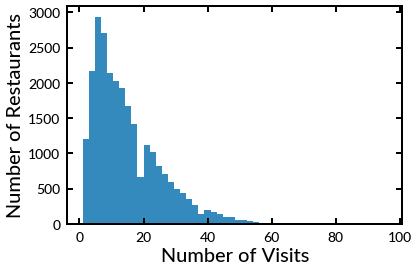

In [9]:
df_v = df.groupby(['camis', 'dba'],as_index=False)['score'].count()
df_v.rename(columns={'score': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
# df_v.head(20).plot.bar(x='dba', y='Count')
plt.hist(df_v.Count, bins=50)
plt.ylabel('Number of Restaurants')
plt.xlabel('Number of Visits')
print(df_v.head(20))

In [10]:
df_single_visits[df_single_visits.camis==41297769]

,camis,dba,boro,zipcode,cuisine_description,inspection_date,action,score,latitude,longitude,grade,violation_code,violation_description,critical_flag,inspection_type
6101,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-10-19,Violations were cited in the following area(s).,6.0,40.836121,-73.943382,A,"[04M, 04L]",[Live roaches present in facility's food and/o...,"[Y, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."
9773,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-09-25,Violations were cited in the following area(s).,80.0,40.836121,-73.943382,NaN,"[04M, 10B, 06F, 10D, 02G, 05D, 10A, 02H, 06C, ...",[Live roaches present in facility's food and/o...,"[Y, N, Y, N, Y, Y, N, Y, Y, Y, Y, N, Y, Y, N, N]","[Cycle Inspection / Initial Inspection, Cycle ..."
28484,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-10-17,Establishment Closed by DOHMH. Violations wer...,115.0,40.836121,-73.943382,NaN,"[10B, 06D, 04H, 10F, 08A, 10D, 06C, 04L, 04N, ...",[Plumbing not properly installed or maintained...,"[N, Y, Y, N, N, N, Y, Y, Y, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."
33310,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-11-28,Violations were cited in the following area(s).,21.0,40.836121,-73.943382,NaN,"[08A, 06C, 10B, 04L, 08C]",[Facility not vermin proof. Harborage or condi...,"[N, Y, N, Y, N]","[Cycle Inspection / Initial Inspection, Cycle ..."
45167,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-09-02,No violations were recorded at the time of thi...,NaN,40.836121,-73.943382,NaN,"[nan, 20F]","[nan, Current letter grade card not posted.]","[nan, N]","[Trans Fat / Initial Inspection, Administrativ..."
49597,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-06-11,Violations were cited in the following area(s).,34.0,40.836121,-73.943382,C,"[10B, 04H, 02G, 06C, 08A, 04M]",[Plumbing not properly installed or maintained...,"[N, Y, Y, Y, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."
50751,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-08-14,Establishment Closed by DOHMH. Violations wer...,79.0,40.836121,-73.943382,NaN,"[05F, 08A, 04K, 04H, 02G, 04M, 04N]",[Insufficient or no refrigerated or hot holdin...,"[Y, N, Y, Y, Y, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
63434,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2018-04-06,Establishment Closed by DOHMH. Violations wer...,51.0,40.836121,-73.943382,NaN,"[08A, 10F, 02B, 10B, 04L, 04M]",[Facility not vermin proof. Harborage or condi...,"[N, N, Y, N, Y, Y]","[Cycle Inspection / Initial Inspection, Cycle ..."
68252,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2016-05-24,Violations were cited in the following area(s).,31.0,40.836121,-73.943382,C,"[06F, 04L, 02G, 10F, 04N, 08A]",[Wiping cloths soiled or not stored in sanitiz...,"[Y, Y, Y, N, Y, N]","[Cycle Inspection / Re-inspection, Cycle Inspe..."
82535,41297769,BROTHERS FISH MARKET,Manhattan,10032.0,Seafood,2017-01-20,Violations were cited in the following area(s).,13.0,40.836121,-73.943382,A,"[06D, 09B, 04M]","[Food contact surface not properly washed, rin...","[Y, N, Y]","[Cycle Inspection / Re-inspection, Cycle Inspe..."


# Look at the temporal features of the data

In [11]:
pd.to_datetime(df_single_visits["inspection_date"]).describe()

count                  134546
unique                   1289
top       2019-03-28 00:00:00
freq                      276
first     2016-01-04 00:00:00
last      2020-01-24 00:00:00
Name: inspection_date, dtype: object

## Year

Text(0, 0.5, 'Count of Inspections')

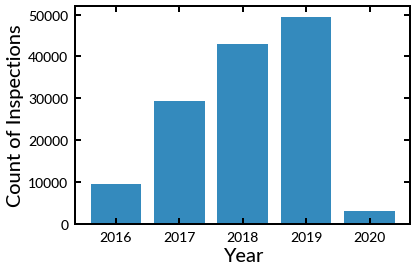

In [13]:
year_hist = df_single_visits.inspection_date.dt.year
year_hist = year_hist.value_counts().sort_index()
year_hist.index = ["2016", "2017", "2018", '2019', '2020']
plt.bar(year_hist.index, year_hist.values)
plt.xlabel("Year")
plt.ylabel("Count of Inspections")

## Month

Text(0, 0.5, 'Count of Inspections')

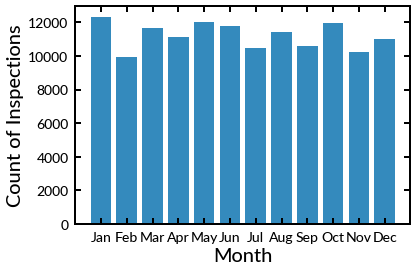

In [14]:
month_hist = pd.to_datetime(df_single_visits["inspection_date"]).dt.month
month_hist = month_hist.value_counts().sort_index()
month_hist.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(month_hist.index, month_hist.values)
plt.xlabel("Month")
plt.ylabel("Count of Inspections")

## Day

Text(0, 0.5, 'Count of Inspections')

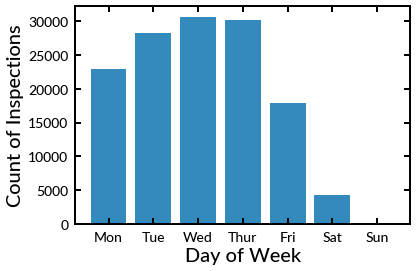

In [15]:
day_hist = pd.to_datetime(df_single_visits["inspection_date"]).dt.weekday
day_hist = day_hist.value_counts().sort_index()
day_hist.index = ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"]
plt.bar(day_hist.index, day_hist.values)
plt.xlabel("Day of Week")
plt.ylabel("Count of Inspections")

# What types of restaurants are being inspected?

Text(0, 0.5, 'Number of Restaurants')

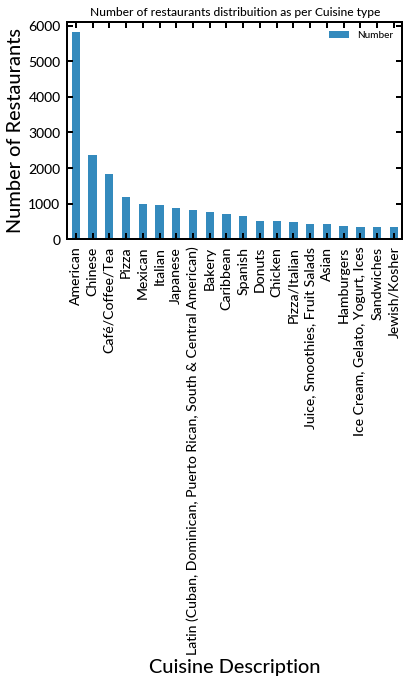

In [16]:
cus = []
cus_n = []
for i in df_single_visits["cuisine_description"].unique():
    cus.append(i)
    cus_n.append(df[df["cuisine_description"]==i]["camis"].nunique())
my_data_cus = { 'Cuisine Description':cus,'Number':cus_n}
my_data_cus = pd.DataFrame(my_data_cus)
my_data_cus.sort_values(by='Number', ascending=False, inplace=True)
my_data_cus.head(20).plot(x="Cuisine Description", y=["Number"], kind="bar")
plt.title('Number of restaurants distribuition as per Cuisine type')
plt.ylabel('Number of Restaurants')


# How many have critical violations?

In [17]:
nested = df_single_visits['critical_flag'].values.tolist()

df_single_visits['critical'] = [1 if 'Y' in sublist else 0 for sublist in nested]

[ 18217 116329]


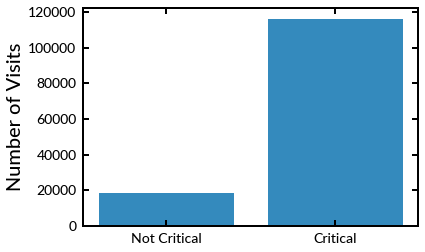

In [18]:
month_hist = df_single_visits["critical"]
month_hist = month_hist.value_counts().sort_index()
month_hist.index = ["Not Critical", "Critical"]
plt.bar(month_hist.index, month_hist.values)
plt.ylabel('Number of Visits')
print(month_hist.values)

In [19]:
70981/df_single_visits.shape[0]

0.527559347732374

So 86% of restaurants visits had a critical violation

Text(0, 0.5, 'Number of Violations')

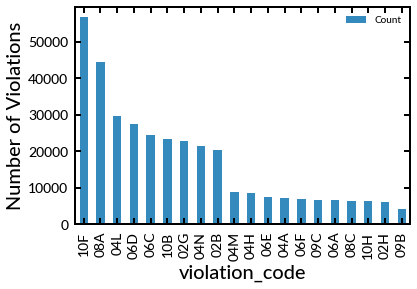

In [20]:
#Now let us check the distribution of Violation Types
df_v = df.groupby(['violation_code'],as_index=False)['camis'].count()
df_v.rename(columns={'camis': 'Count'}, inplace=True)
df_v.sort_values(by='Count', ascending=False, inplace=True)
df_v.reset_index(drop=True,inplace=True)
df_v.head(20).plot.bar(x='violation_code', y='Count')
plt.ylabel('Number of Violations')

In [21]:
codes = df.violation_code.unique()

In [22]:
np.sort([c for c in codes if isinstance(c, str)])

array(['02A', '02B', '02C', '02D', '02E', '02F', '02G', '02H', '02I',
       '02J', '03A', '03B', '03C', '03D', '03E', '03F', '03G', '04A',
       '04B', '04C', '04D', '04E', '04F', '04G', '04H', '04I', '04J',
       '04K', '04L', '04M', '04N', '04O', '05A', '05B', '05C', '05D',
       '05E', '05F', '05H', '06A', '06B', '06C', '06D', '06E', '06F',
       '06G', '06H', '06I', '07A', '08A', '08B', '08C', '09A', '09B',
       '09C', '10A', '10B', '10C', '10D', '10E', '10F', '10G', '10H',
       '10I', '10J', '15A1', '15E2', '15E3', '15F1', '15F2', '15F6',
       '15F7', '15F8', '15G7', '15I', '15J', '15K', '15L', '15S', '15T',
       '16A', '16B', '16C', '16D', '16E', '16F', '17A1', '17A3', '18B',
       '18C', '18D', '18F', '18G', '19A1', '19A3', '20A', '20D', '20E',
       '20F', '22A', '22B', '22C', '22E', '22F', '22G'], dtype='<U4')

Total Number of times Restaurants closed by the Health Inspectors are 16450


Text(0, 0.5, 'Number of Closings')

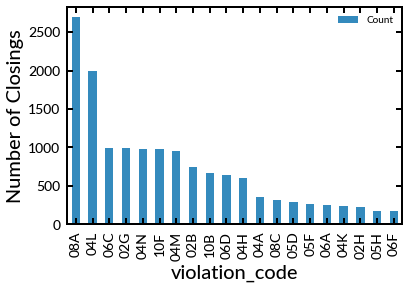

In [23]:
my_data_closed = df[df['action'].str.contains("Establishment Closed|Establishment re-closed")]
print ('Total Number of times Restaurants closed by the Health Inspectors are',my_data_closed['action'].count())

my_data_cr = my_data_closed.groupby(['violation_code'],as_index=False)['camis'].count()
my_data_cr.rename(columns={'camis': 'Count'}, inplace=True)
my_data_cr.sort_values(by='Count', ascending=False, inplace=True)
my_data_cr.reset_index(drop=True,inplace=True)
my_data_cr.head(20).plot.bar(x='violation_code', y='Count')
plt.ylabel('Number of Closings')

# Look at the spatial data!

In [24]:
df_single_visits['latitude'].replace(0, np.nan, inplace=True)
df_single_visits['longitude'].replace(0, np.nan, inplace=True)

Text(0, 0.5, 'Latitude')

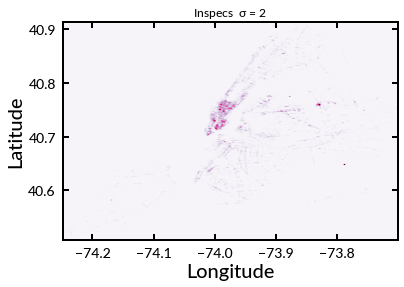

In [25]:
fig, ax = plt.subplots(1,1)

x = df_single_visits.longitude
y = df_single_visits.latitude

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("Inspecs  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Other data

In [26]:
threeoneone = pd.read_csv('./data/311.csv')
nypd = pd.read_csv('./data/nypd.csv')

# Replace the missing lats and lons with nan
threeoneone['latitude'].replace(0, np.nan, inplace=True)
threeoneone['longitude'].replace(0, np.nan, inplace=True)
nypd['latitude'].replace(0, np.nan, inplace=True)
nypd['longitude'].replace(0, np.nan, inplace=True)

# Do date things
threeoneone.created_date = pd.to_datetime(threeoneone.created_date)
nypd.complaint_date = pd.to_datetime(nypd.complaint_date)


# make a column to store which day of the week it is... 
# Remember that Monday is 0 Sunday = 6
threeoneone['weekday'] = threeoneone.created_date.dt.weekday
nypd['weekday'] = nypd.complaint_date.dt.weekday

# 311

Text(0, 0.5, 'Latitude')

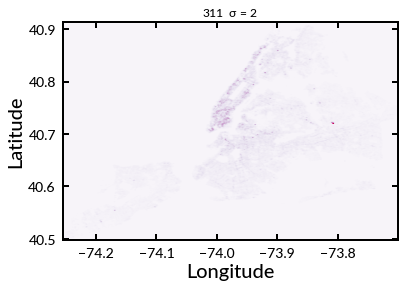

In [27]:
fig, ax = plt.subplots(1,1)

x = threeoneone.longitude
y = threeoneone.latitude

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("311  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [28]:
threeoneone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
created_date      1000000 non-null datetime64[ns]
agency            1000000 non-null object
complaint_type    1000000 non-null object
descriptor        997937 non-null object
location_type     571563 non-null object
incident_zip      962093 non-null float64
address_type      985165 non-null object
city              961809 non-null object
facility_type     179266 non-null object
borough           1000000 non-null object
latitude          955827 non-null float64
longitude         955827 non-null float64
weekday           1000000 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(1), object(8)
memory usage: 99.2+ MB


In [29]:
threeoneone[threeoneone.agency == 'DSNY'].complaint_type.unique()

array(['Sanitation Condition', 'Missed Collection (All Materials)',
       'Derelict Vehicles', 'Dirty Conditions', 'Recycling Enforcement',
       'Vacant Lot', 'Other Enforcement', 'Derelict Bicycle', 'Snow',
       'Graffiti', 'Sweeping/Inadequate', 'Missed Collection',
       'Employee Behavior', 'Snow Removal', 'Electronics Waste',
       'Litter Basket / Request', 'Sweeping/Missed',
       'Overflowing Litter Baskets', 'Request Xmas Tree Collection',
       'Request Large Bulky Item Collection',
       'Electronics Waste Appointment', 'Sweeping/Missed-Inadequate',
       'Adopt-A-Basket', 'Foam Ban Enforcement', 'Collection Truck Noise',
       'Overflowing Recycling Baskets'], dtype=object)

In [30]:
threeoneone[threeoneone.agency == 'DEP'].complaint_type.unique()

array(['Water System', 'Noise', 'Sewer', 'Air Quality',
       'Hazardous Materials', 'Water Quality', 'Industrial Waste',
       'Water Conservation', 'Lead', 'Asbestos', 'FATF', 'Plant', 'SRDE',
       'ATF', 'FCST'], dtype=object)

In [31]:
threeoneone[threeoneone.agency == 'DOHMH'].complaint_type.unique()

array(['Rodent', 'Unsanitary Animal Pvt Property', 'Food Establishment',
       'Food Poisoning', 'Asbestos', 'Smoking', 'Indoor Sewage',
       'Animal Facility - No Permit', 'Pet Shop',
       'Illegal Animal Kept as Pet', 'Mobile Food Vendor',
       'Indoor Air Quality', 'Harboring Bees/Wasps', 'Unleashed Dog',
       'Non-Residential Heat', 'Poison Ivy', 'Beach/Pool/Sauna Complaint',
       'Day Care', 'Standing Water', 'Mosquitoes', 'Window Guard', 'Mold',
       'Unsanitary Pigeon Condition', 'Illegal Animal Sold', 'Tattooing',
       'Trans Fat', 'Unlicensed Dog', 'Unsanitary Animal Facility',
       'Calorie Labeling', 'Cooling Tower', 'Drinking Water',
       'X-Ray Machine/Equipment', 'Radioactive Material', 'Lifeguard',
       'Bottled Water', 'Tanning', 'Construction Lead Dust',
       'Peeling Paint', 'Forms', 'Asbestos/Garbage Nuisance',
       'Trapping Pigeon', 'LEAD', 'MOLD'], dtype=object)

In [32]:
from utils.strings import DSNY_311, DEP_311, DOHMH_311

In [33]:
DOHMH_311

['Mobile Food Vendor',
 'Food Establishment',
 'Smoking',
 'Trans Fat',
 'Calorie Labeling',
 'Indoor Air Quality',
 'Rodent',
 'Standing Water',
 'Indoor Sewage',
 'Drinking Water',
 'Bottled Water',
 'Non-Residential Heat',
 'Food Poisoning',
 'Unsanitary Pigeon Condition',
 'Mold',
 'Radioactive Material',
 'Cooling Tower',
 'Asbestos/Garbage Nuisance']

In [34]:
dsny_mask = threeoneone.complaint_type.isin(DOHMH_311)

Text(0, 0.5, 'Latitude')

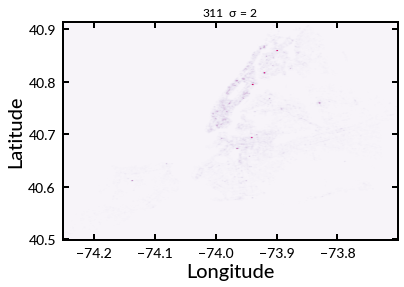

In [35]:
fig, ax = plt.subplots(1,1)

x = threeoneone.longitude[dsny_mask]
y = threeoneone.latitude[dsny_mask]

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("311  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# NYPD

In [62]:
nypd = pd.read_csv('./data/nypd.csv')
nypd.complaint_date = pd.to_datetime(nypd.complaint_date)

In [63]:
nypd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
complaint_date           1000000 non-null datetime64[ns]
complaint_code           1000000 non-null int64
complaint_description    999925 non-null object
offense_lvl              1000000 non-null object
boro                     999360 non-null object
premisis_type            996090 non-null object
latitude                 998740 non-null float64
longitude                998740 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 61.0+ MB


In [64]:
nypd.complaint_date.describe()

count                 1000000
unique                    777
top       2017-01-01 00:00:00
freq                     2140
first     2016-01-02 00:00:00
last      2018-02-16 00:00:00
Name: complaint_date, dtype: object

In [65]:
# match the descriptions to the complaint codes

keys = list(nypd.groupby(['complaint_code', 'complaint_description']).groups.keys())

In [66]:
keys

[(341, 'PETIT LARCENY'),
 (578, 'HARRASSMENT 2'),
 (126, 'MISCELLANEOUS PENAL LAW'),
 (113, 'FORGERY'),
 (106, 'FELONY ASSAULT'),
 (340, 'FRAUDS'),
 (344, 'ASSAULT 3 & RELATED OFFENSES'),
 (351, 'CRIMINAL MISCHIEF & RELATED OF'),
 (109, 'GRAND LARCENY'),
 (235, 'DANGEROUS DRUGS'),
 (118, 'DANGEROUS WEAPONS'),
 (105, 'ROBBERY'),
 (110, 'GRAND LARCENY OF MOTOR VEHICLE'),
 (114, 'ARSON'),
 (352, 'CRIMINAL TRESPASS'),
 (107, 'BURGLARY'),
 (117, 'DANGEROUS DRUGS'),
 (121, 'CRIMINAL MISCHIEF & RELATED OF'),
 (353, 'UNAUTHORIZED USE OF A VEHICLE'),
 (361, 'OFF. AGNST PUB ORD SENSBLTY &'),
 (359, 'OFFENSES AGAINST PUBLIC ADMINI'),
 (348, 'VEHICLE AND TRAFFIC LAWS'),
 (125, 'NYS LAWS-UNCLASSIFIED FELONY'),
 (347, 'INTOXICATED & IMPAIRED DRIVING'),
 (112, 'THEFT-FRAUD'),
 (358, 'OFFENSES INVOLVING FRAUD'),
 (233, 'SEX CRIMES'),
 (116, 'SEX CRIMES'),
 (236, 'DANGEROUS WEAPONS'),
 (343, 'OTHER OFFENSES RELATED TO THEF'),
 (343, 'THEFT OF SERVICES'),
 (355, 'OFFENSES AGAINST THE PERSON'),
 (232, 'P

In [67]:
# gonna put this in utils/strings.py 
complaint_codes = dict(keys)
# invert to use the descriptions to get the codes
complaint_desc = dict([[v,k] for k,v in complaint_codes.items()])

complaint_desc

{'PETIT LARCENY': 341,
 'HARRASSMENT 2': 578,
 nan: 356,
 'FORGERY': 113,
 'FELONY ASSAULT': 106,
 'FRAUDS': 340,
 'ASSAULT 3 & RELATED OFFENSES': 344,
 'CRIMINAL MISCHIEF & RELATED OF': 121,
 'GRAND LARCENY': 109,
 'DANGEROUS DRUGS': 117,
 'DANGEROUS WEAPONS': 236,
 'ROBBERY': 105,
 'GRAND LARCENY OF MOTOR VEHICLE': 110,
 'ARSON': 114,
 'CRIMINAL TRESPASS': 352,
 'BURGLARY': 107,
 'UNAUTHORIZED USE OF A VEHICLE': 353,
 'OFFENSES AGAINST PUBLIC ADMINI': 359,
 'VEHICLE AND TRAFFIC LAWS': 348,
 'OTHER STATE LAWS (NON PENAL LA': 125,
 'INTOXICATED & IMPAIRED DRIVING': 347,
 'THEFT-FRAUD': 112,
 'OFFENSES INVOLVING FRAUD': 358,
 'SEX CRIMES': 116,
 'THEFT OF SERVICES': 343,
 'OFFENSES AGAINST THE PERSON': 355,
 'POSSESSION OF STOLEN PROPERTY': 111,
 'RAPE': 104,
 'ENDAN WELFARE INCOMP': 120,
 'ADMINISTRATIVE CODE': 365,
 'MISCELLANEOUS PENAL LAW': 678,
 'OTHER STATE LAWS (NON PENAL LAW)': 364,
 'PETIT LARCENY OF MOTOR VEHICLE': 342,
 'MURDER & NON-NEGL. MANSLAUGHTER': 101,
 'DISORDERLY CON

The only things we are really interested (at least initially) in are:
robbery, burglary and maybe criminal tresspassing.... start with burglary... 

In [68]:
nypd_burglary = nypd[nypd.complaint_code == complaint_desc['BURGLARY']]

In [69]:
nypd_burglary.complaint_date.describe()

count                   26577
unique                    777
top       2016-11-23 00:00:00
freq                       70
first     2016-01-02 00:00:00
last      2018-02-16 00:00:00
Name: complaint_date, dtype: object

# Seems that we are missing a bunch of data from the NYPD

The full data set has more data, but I don't know why we are missing data. Might have to use the full set.

In [44]:
nypd = pd.read_csv('./data/full/NYPD_Complaint_Data_Historic.csv')

/home/boada/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
nypd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500870 entries, 0 to 6500869
Data columns (total 35 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         object
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
ADDR_PCT_CD          float64
RPT_DT               object
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
BORO_NM              object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
JURIS_DESC           object
JURISDICTION_CODE    float64
PARKS_NM             object
HADEVELOPT           object
HOUSING_PSA          object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP       object
SUSP_RACE            object
SUSP_SEX             object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon              object
PATROL_BORO          object
STATION_NAME 

In [46]:
nypd.CMPLNT_FR_DT = pd.to_datetime(nypd.CMPLNT_FR_DT, errors='coerce')

In [47]:
nypd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500870 entries, 0 to 6500869
Data columns (total 35 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         datetime64[ns]
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
ADDR_PCT_CD          float64
RPT_DT               object
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
BORO_NM              object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
JURIS_DESC           object
JURISDICTION_CODE    float64
PARKS_NM             object
HADEVELOPT           object
HOUSING_PSA          object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP       object
SUSP_RACE            object
SUSP_SEX             object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon              object
PATROL_BORO          object
STATI

In [48]:
nypd.dropna(subset=['CMPLNT_FR_DT'], inplace=True)

In [49]:
nypd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500119 entries, 0 to 6500869
Data columns (total 35 columns):
CMPLNT_NUM           int64
CMPLNT_FR_DT         datetime64[ns]
CMPLNT_FR_TM         object
CMPLNT_TO_DT         object
CMPLNT_TO_TM         object
ADDR_PCT_CD          float64
RPT_DT               object
KY_CD                int64
OFNS_DESC            object
PD_CD                float64
PD_DESC              object
CRM_ATPT_CPTD_CD     object
LAW_CAT_CD           object
BORO_NM              object
LOC_OF_OCCUR_DESC    object
PREM_TYP_DESC        object
JURIS_DESC           object
JURISDICTION_CODE    float64
PARKS_NM             object
HADEVELOPT           object
HOUSING_PSA          object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP       object
SUSP_RACE            object
SUSP_SEX             object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon              object
PATROL_BORO          object
STATI

### This is how we are going to use the full data to select only the stuff we need.

In [50]:
end_date = pd.to_datetime('2019-01-01')
start_date = end_date - pd.to_timedelta(90, unit='days')
# can also use
# import datetime as dt
# dt.timedelta(days=5)
nypd_test = select_by_date(nypd, start_date, end_date)[nypd.KY_CD == complaint_desc['BURGLARY']]

/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


<IPython.core.display.Javascript object>


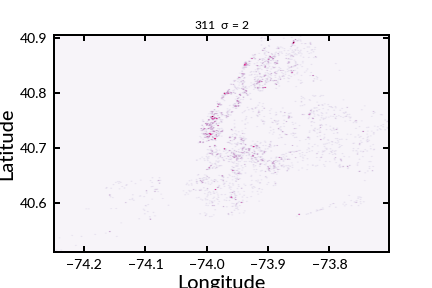

Text(0, 0.5, 'Latitude')

In [60]:
%matplotlib notebook
fig, ax = plt.subplots(1,1)

x = nypd_test.Longitude
y = nypd_test.Latitude

s = 2

img, extent, xedges, yedges = mk_heatmap(x, y, s, bins=1000)
ax.imshow(img, extent=extent, origin='lower', cmap=cm.PuRd)
ax.set_title("311  $\sigma$ = %d" % s)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [52]:
value_heatmap(-74, 40.723, xedges, yedges, img)

0.109899813927673

In [53]:
bus = pd.read_csv('./data/full/Legally_Operating_Businesses.csv')

/home/boada/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201167 entries, 0 to 201166
Data columns (total 27 columns):
DCA License Number               201167 non-null object
License Type                     201167 non-null object
License Expiration Date          201134 non-null object
License Status                   201167 non-null object
License Creation Date            201167 non-null object
Industry                         201167 non-null object
Business Name                    201117 non-null object
Business Name 2                  32785 non-null object
Address Building                 127966 non-null object
Address Street Name              128714 non-null object
Secondary Address Street Name    1985 non-null object
Address City                     200459 non-null object
Address State                    200337 non-null object
Address ZIP                      200435 non-null object
Contact Phone Number             191462 non-null object
Address Borough                  127776 non-null obj

In [55]:
np.sort(bus.Industry.unique())

array(['Amusement Arcade', 'Amusement Device Permanent',
       'Amusement Device Portable', 'Amusement Device Temporary',
       'Auction House Premises', 'Auctioneer', 'Bingo Game Operator',
       'Booting Company', 'Cabaret', 'Car Wash', 'Catering Establishment',
       'Commercial Lessor', 'Dealer In Products',
       'Debt Collection Agency', 'Electronic & Appliance Service',
       'Electronic Cigarette Dealer', 'Electronics Store',
       'Employment Agency', 'Games of Chance', 'Gaming Cafe', 'Garage',
       'Garage and Parking Lot', 'General Vendor',
       'General Vendor Distributor', 'Home Improvement Contractor',
       'Home Improvement Salesperson', 'Horse Drawn Cab Owner',
       'Horse Drawn Driver', 'Laundries', 'Laundry', 'Laundry Jobber',
       'Locksmith', 'Locksmith Apprentice',
       'Motion Picture Projectionist', 'Newsstand', 'Parking Lot',
       'Pawnbroker', 'Pedicab Business', 'Pedicab Driver',
       'Pool or Billiard Room', 'Process Server Individual',

In [56]:
bus2 = bus.dropna(subset=['BBL'])

In [57]:
bus2

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location
255,2062603-DCA,Business,12/31/2021,Active,12/06/2017,Laundries,XING BIN LAUNDROMAT INC.,NaN,10118,LIBERTY AVE,...,410.0,32.0,4201974,4095220009,QN55,94.0,Laundry Type: Retail Laundry,-73.839280,40.681305,"(40.68130477447896, -73.83928016812561)"
476,2034972-DCA,Business,03/31/2020,Active,03/25/2016,Stoop Line Stand,Rosalie Tuzzino,NaN,140,MULBERRY ST,...,102.0,1.0,1077173,1002370006,MN24,41.0,"Product Category: Ice Cream, 4 foot stands: 1,...",-73.997619,40.718663,"(40.718663472948315, -73.99761907513695)"
481,2073413-1-DCA,Business,11/30/2019,Inactive,06/14/2018,Electronic Cigarette Dealer,ANSHROOP CORPORATION,7 ELEVEN STORE #35764A,6031,METROPOLITAN AVE,...,405.0,30.0,4061108,4027370037,QN21,603.0,NaN,-73.904270,40.712849,"(40.7128487179766, -73.90426990115682)"
484,2054177-DCA,Business,12/31/2020,Inactive,06/08/2017,Electronics Store,CSR PENN INC,NaN,937,PENNSYLVANIA AVE,...,305.0,42.0,3327452,3043910001,BK82,1104.0,NaN,-73.888084,40.655199,"(40.65519935647488, -73.88808402244312)"
486,2013293-DCA,Business,06/30/2020,Active,09/12/2014,Electronic & Appliance Service,NEPTUNE AIR CONDITIONING INC,NaN,575,LEXINGTON AVE,...,106.0,4.0,1036461,1013060023,MN19,100.0,NaN,-73.971827,40.757216,"(40.757215588426654, -73.97182746323014)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201162,2026189-2-DCA,Business,12/31/2020,Active,07/27/2015,Tobacco Retail Dealer,SHREEJI 315 INC,NaN,315,1ST AVE,...,106.0,2.0,1.02049e+06,1.00924e+09,MN21,48.0,NaN,-73.980569,40.733903,"(40.73390349266078, -73.98056937440188)"
201163,1003888-DCA,Business,07/31/2021,Active,02/25/1999,Secondhand Dealer - General,"SOSA, ROCK H",NEW SOSA ELECTRONICS,261,WYCKOFF AVE,...,304.0,37.0,3.07577e+06,3.03311e+09,BK77,441.0,NaN,-73.914197,40.701265,"(40.701265402071414, -73.91419725787644)"
201164,1252203-DCA,Business,09/15/2013,Inactive,04/14/2007,Sidewalk Cafe,"SALSA SALON, INC.",NaN,47,E 12TH ST,...,102.0,2.0,1.08468e+06,1.00564e+09,MN23,61.0,"Sidewalk Cafe Type: Unenclosed, Square Feet: 7...",-73.991683,40.733463,"(40.73346292620985, -73.99168295346709)"
201165,2082881-2-DCA,Business,11/30/2020,Active,03/05/2019,Electronic Cigarette Dealer,M & E CANDY STORE CORP,NaN,148,MONTAGUE ST,...,302.0,33.0,3.00208e+06,3.00249e+09,BK09,502.0,NaN,-73.993329,40.694518,"(40.69451761556611, -73.9933286123902)"


In [58]:
bus[bus['BBL'] == 4107280035]

,DCA License Number,License Type,License Expiration Date,License Status,License Creation Date,Industry,Business Name,Business Name 2,Address Building,Address Street Name,...,Community Board,Council District,BIN,BBL,NTA,Census Tract,Detail,Longitude,Latitude,Location


In [59]:
bus[bus.industry=='General Vendor'
]

AttributeError: 'DataFrame' object has no attribute 'industry'

In [ ]:
rest = pd.read_csv('./data/full/DOHMH_New_York_City_Restaurant_Inspection_Results.csv')

In [ ]:
rest.info()

In [ ]:
rest.head(5).T

In [ ]:
rest.iloc[0].BBL

# Take away from business data

Basically, the business data doesn't seem to have a good way to match it with the restaurant data. Maybe in the future, I will think about this more, but right now it looks like I am just gonna drop it.

Potentially, we could make another map looking at the different types of businesses around each of the restaurants. Maybe restaurants near vape shops have some sort of correlation.

# Weather!

In [ ]:
weather = pd.read_csv('./data/NYC_historical_weather.csv')

In [ ]:
weather.loc[1000:1004].T

In [ ]:
weather.DATE = pd.to_datetime(weather.DATE)

In [ ]:
weather.plot('DATE', 'TMAX')

# Merge the weather data with the inspections

In [ ]:
df_single_visits = df_single_visits.merge(weather[['DATE', 'TMAX']], left_on='inspection_date', right_on='DATE')
# drop the extra date column
df_single_visits.drop(labels='DATE', axis=1, inplace=True)

# Now we want to see if can calculate a few things about the inspections

* Time since last inspection -- apparently, that is super easy
* Last inspection critical -- y/n
* Last inspection grade (or maybe score)

In [ ]:
# Buddy's Burrito and Taco Bar for testing
df_test = df_single_visits[df_single_visits.camis==40393243]

In [ ]:
df_test['time_since'] = df_test.groupby('camis')['inspection_date'].diff().apply(lambda x: x.days)

In [ ]:
df_test

Now try to say if it had a previous critical

In [ ]:
df_test['past_critical'] = df_test.groupby(['camis'])['critical'].shift()

In [ ]:
df_test

Seems we can do the same thing for previous grade and score

In [ ]:
df_test['past_grade'] = df_test.groupby(['camis'])['grade'].shift()
df_test['past_score'] = df_test.groupby(['camis'])['score'].shift()

In [ ]:
df_test